In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

def imshow(img, ax=None, title="", bgr=True):
    # since plt and cv2 have different RGB sorting
    if bgr:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    if ax == None:
        plt.imshow(img.astype(np.uint8))
        plt.axis("off")
        plt.title(title)
    else:
        ax.imshow(img.astype(np.uint8))
        ax.set_axis_off()
        ax.set_title(title)
        
plt.rcParams["figure.figsize"] = (12,6)

## Affine Transformations
$$\begin{bmatrix}x'\\y'\end{bmatrix} = 
\begin{bmatrix}a&b&e\\c&d&f\end{bmatrix} \begin{bmatrix}x\\y\\1\end{bmatrix} $$
is the combination of a linear transformation $\begin{bmatrix}a&b\\c&d\end{bmatrix}$ plus a translation $\begin{bmatrix}e\\f\end{bmatrix} $

#### Properties
- Origin $\Rightarrow (e, f)$
- Lines map to lines 
- Parallel lines remain parallel
- Preserves ratios
- Closed under composition
- Rectangles go to parallelograms

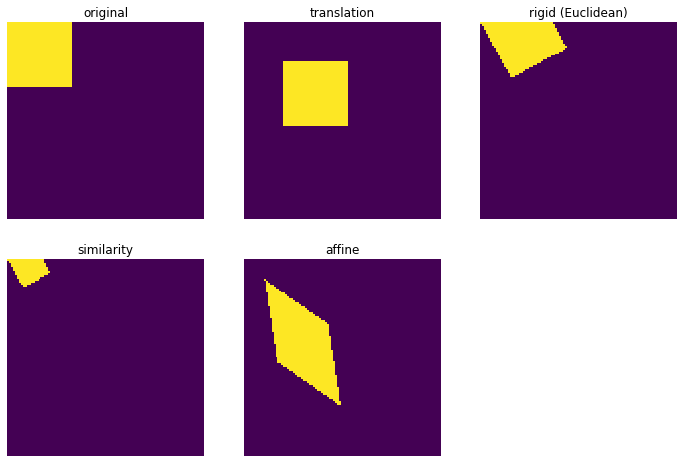

In [2]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
img = np.zeros((100, 100))

img[:33, :33] = 1
imshow(img, axs[0][0], title="original", bgr=False)

M_trans = np.array([[1, 0, 20], [0, 1., 20]])
img_trans = cv2.warpAffine(img, M_trans, (100, 100))
imshow(img_trans, axs[0][1], title="translation", bgr=False)

M_rotation = np.array([[np.cos(0.5), np.sin(0.5), 0], 
                       [-np.sin(0.5), np.cos(0.5), 0]])
img_rotation = cv2.warpAffine(img, M_rotation, (100, 100))
imshow(img_rotation, axs[0][2], title="rigid (Euclidean)", bgr=False)

M_sim = np.array([[np.cos(0.5), np.sin(0.5), 0], 
                       [-np.sin(0.5), np.cos(0.5), 0]]) * 0.5
img_sim = cv2.warpAffine(img, M_sim, (100, 100))
imshow(img_sim, axs[1][0], title="similarity", bgr=False)

M_aff = np.array([[1, 0.2, 10], 
                  [0.7, 1.3, 10]])
img_aff = cv2.warpAffine(img, M_aff, (100, 100))
imshow(img_aff, axs[1][1], title="affine", bgr=False)

axs[1][2].set_axis_off()

## Projective Transformations
$$w\begin{bmatrix}x'\\y'\\1\end{bmatrix} = 
\begin{bmatrix}a&b&e\\c&d&f\\g&h&i\end{bmatrix} \begin{bmatrix}x\\y\\1\end{bmatrix} $$
Note that this is an expansion of affine transformation, when $g=h=0$ and $i=1$
#### Properties
 - origin does not necessarily map to origin
 - Lines map to lines
 - __parallel are not necessarily remain parallel__
 - __Do not__ preserve ratios
 - closed under composition
 - rectangles goes to quadrilateral

### Solving Homographies
Let $(x_i,y_i)$ be a point on the reference (model) image, and $(x_i',y_i')$ be its matching in the test image, $H_{3\times 3}$ be the projective matrix. 
So that 
$$a\begin{bmatrix}x_i'\\y_i'\\1\end{bmatrix} = 
\begin{bmatrix}h_{00}&h_{01}&h_{02}\\
h_{10}&h_{11}&h_{12}\\h_{20}&h_{21}&h_{22}\end{bmatrix} \begin{bmatrix}x_i\\y_i\\1\end{bmatrix} $$
We need to solve the 9 unknowns $h_{[0:2, 0:2]}$ 
First, note that $$a = h_{20}x_i + h_{21}y_i + h_{22}$$
so that $$ax_i' = h_{00}x_i + h_{01}y_1 + h_{02}\Rightarrow x_i' = \frac{h_{00}x_i + h_{01}y_1 + h_{02}}{h_{20}x_i + h_{21}y_i + h_{22}} $$
$$y_i' = \frac{h_{10}x_i + h_{11}y_1 + h_{12}}{h_{20}x_i + h_{21}y_i + h_{22}}$$
rewrite them as linear equations
\begin{align*}
-(h_{20}x_i + h_{21}y_i + h_{22})x_i' + h_{00}x_i + h_{01}y_1 + h_{02} = 0\\
-(h_{20}x_i + h_{21}y_i + h_{22})y_i' + h_{10}x_i + h_{11}y_1 + h_{12} = 0
\end{align*}
i.e. 
$$\begin{bmatrix}
x_i &y_i&1&0&0&0&-x_i'x_i&-x_i'y_i &-x_i'\\
0 &0&0&x_i&y_i&1&-y_i'x_i&-y_i'y_i &-y_i'
\end{bmatrix}
h_F = \vec 0$$
where $h_F=[h_{00}, h_{01},...,h_{21},h_{22}]^T$ is the flatten vector of $H$

Since we have $n$ sets of matching points, we can have 
$$A_{2n\times 9} h_{F_9\times 1} = \vec 0_{2n}$$
and we want to find 
$$h = arg\min \|Ah\|_2^2$$

Since $h$ is only defined up to scale, we can first solve for unit vector and then multiply back scale. so that we can add constraint 
$\|h\|_2 = 1$ and 
$$h = arg\min_{\|h\|_2=1}\|Ah\|_2^2$$
For constrained optimization, we use method of Lagrange Multipliers
where $\hat h = $eigenvector of $A^TA$ with smallest eigenvalue. 

Notice that although we seem to have $9$ unknowns, we actually only have $8$, since the last one is calculated from the constraint. So that we only need $4$ matching to form a deterministic or over-deterministic system. 

## Camera Modeling Projection
### Set up
To simplify the model, assume we have a pinhole camera, and we are working with the virtual image plane, since the real image plane is upside down. 

For the 3-D coordinate system, using the __right handed__ coordinate system  
call the __optical center__ or __cemera center__ $C:= (0,0)$  
$Z$ axis be the __optical__ or __principal__ axis, which will be orthogonal to the image plane.  
$X,Y$ axes are parallel to the image.  
So that $Z$-axis points to the object, $X$-axis points away and $Y$-axis points top. 

__principal point__ $p$: the optical axis intersects the image plane.  
__focal length__ $f:=d(C,p)$ is the distance from the camera center to the principal point.  
__image coordinate system__ the $(x,y)$ coordinate used to represent the 2D image plane. Let the origin be the bottom left corner, so that $p=(p_x,p_y)$

Taking some point $Q$ living in the 3D, connected to the origin, call the connection line __projection line__. Call its intersection with the image plane $q$. However, we can notice that every point on the __projection line__ will be mapped to $q$ in the 2D image. 

### Equations
Consider the point $Q = (X,Y,Z)^T$, then its corresponding projection point $q=(X\frac{f}{Z}, Y\frac{f}{Z},f)$ using similar triangles. In the 2D projection space, $q = p + (X\frac{f}{Z}, Y\frac{f}{Z}) = (X\frac{f}{Z} + p_x, Y\frac{f}{Z}+p_y)$

### Homogeneous Coordinates
Add a $1$ for the vector, e.g. $(x,y)\Rightarrow [x,y,1]^T$. In homogeneous coordinates, scaling doesn't affect anything. i.e. $[x,y,1]^T \sim [wx,wy,w]^T$. Therefore, we can write $q$ as 
$$\hat q = \begin{bmatrix}X\frac{f}{Z}+p_x\\Y\frac{f}{Z}+p_y\\1 \end{bmatrix}\sim \begin{bmatrix}fX+Zp_x\\fY+Zp_y\\Z \end{bmatrix}$$
Then, the mapping from $Q$ to $q$ is 

$$
\begin{bmatrix}fX+Zp_x\\fY+Zp_y\\Z \end{bmatrix} 
= \begin{bmatrix}f&0&p_x \\ 0&f&p_y \\ 0&0&1\end{bmatrix}
\begin{bmatrix}X\\Y\\Z \end{bmatrix}
$$
$$\hat q = KQ, q = \hat q / Z$$
$K$ is the __camera calibration matrix__ or __intrinsic parameter matrix__. The parameters in $K$ are called __internal camera parameters__. 

### Some properties
- Many to one: any points along same ray map to same point
- Points, lines, and planes are preserved 
- Any line through principal point projects to a point
- Any plane through principal point projects to line

### vainishing points 
All lines in the same direction in 3D will intersect at the same vanishing point in 2D. 

Consider a line that pass through $V$ with direction $D$, i.e. the line $X = V+tD$

$$KX = \begin{bmatrix}f&0&p_x \\ 0&f&p_y \\ 0&0&1\end{bmatrix}
\begin{bmatrix}V_x+tD_x \\ V_y+tD_y \\ V_z+tD_z\end{bmatrix} = 
\begin{bmatrix}fV_x+ftD_x + p_xV_z + tp_xD_z\\ fV_y+ftD_y + p_yV_z + tp_yD_z \\ V_z+tD_z\end{bmatrix}$$

so that the project point $(x, y)$ will be 
$(x,y) = \lim_{t\rightarrow\infty} (\frac{fV_x+ftD_x + p_xV_z + tp_xD_z}{V_z + tD_z}, \frac{fV_y+ftD_y + p_yV_z + tp_yD_z}{V_z + tD_z}) = (\frac{fD_x + p_xD_z}{D_z}, \frac{fD_y+p_yD_z}{D_z})$
is only about $D$ and independent of $V$. 

However, lines parallel to image plane are still parallel, we say that they intersect at infinity. 
Consider $X_1,X_2$ be two line parallel to the image plane, i.e. $V_z = 0, D_{1z}=D_{2z}$ so that the distance (only demonstrate $x$-distance)

\begin{align*}d_x &= \frac{fV_{1x}+ftD_x + p_xV_{1z} + tp_xD_z}{V_{1z} + tD_z} - \frac{fV_{2x}+ftD_x + p_xV_{2z} + tp_xD_z}{V_{2z} + tD_z}\\
&= \frac{fV_{1x}+ftD_x + p_xV_{1z}}{V_{1z}} - \frac{fV_{2x}+ftD_x + p_xV_{2z}}{V_{2z}}&D_z = 0\\
&=C + \frac{tfD_x(V_{2z} - V_{1z})}{V_{1z}V_{2z}}\\
&= C + 0&V_{1z}=V_{2z}\end{align*}

#### Example
Suppose we have a photo taken from a car with a camera on top, and we know the camera intrinsic matrix $K$, WTF the incline of the hill $\theta$. 

Since the vertical lines now is not parallel to the image plane (the image plane is perpendicular to the inclined ground), we can find the vanishing points in these 2D lines, which is $[w\cdot vp_x, w\cdot vp_y, w]^T$. Therefore, 
$$\begin{bmatrix}w\cdot vp_x\\w\cdot vp_y\\w\end{bmatrix}=KD\Rightarrow D = wK^{-1}\begin{bmatrix} vp_x\\vp_y\\1\end{bmatrix}$$
Then, we can find $D$ and normalizes it. 

### Vanishing Line
Parallel lines in 3D projects to intersected lines in 2D. However, the converse is not necessarily true.

For lines on the same 3D plane, the vanishing points lie on a line, i.e. __vanishing line__. The ground plane is the horizon line. 

Parallel plnes in 3D the the same horizon line in the image. 

### Camera Coordinate System
Since we are measuring everything from 2D images taken by the camera, we need to project the 3D points onto our camera coordinate system, so that we can describe them and get them back. 

To do such projection, we need 
 - Camera __position__ $c$ (in world coordinates)
 - Camera __orientation__ $(\vec u,\vec v,\vec w)$ (in world coordinates)
 - $K$
 
So that for point $Q$ in the world coordinates,  
$Q-c$ is the projection in the camera coordinates,  
$R\begin{bmatrix}u&v&w\end{bmatrix}=I$ looking for rotation to canonical orientation. Then, because orientation is orthogonal, $RR^T = I\Rightarrow R = \begin{bmatrix}u^T&v^T&w^T\end{bmatrix}$

Therefore, the camera coordinate for $(x,y,z)$ in world coordinate is
$$\begin{bmatrix}X'\\Y'\\Z'\end{bmatrix} = R(\begin{bmatrix}X\\Y\\Z\end{bmatrix} - c) = \begin{bmatrix}R&-Rc\end{bmatrix}\begin{bmatrix}X\\Y\\Z\\1\end{bmatrix}$$

### Projection Matrix
We can describe all the cumulative effect of all intrinsic and extrinsic parameters using the projection matrix $P$. so that the 2D projection $(x,y)$ from $(x,y,z)$ can be described through homogeneous coordinates
$$q = \begin{bmatrix}ax\\ay\\a\end{bmatrix} = P\begin{bmatrix}x\\y\\z\\1\end{bmatrix}$$
Where to get a point $q$ in the image plane, we need to compute $P[x,y,z,1]^T$, and divide all coordinates with the third coordinate, and drop the last coordinate. 

$$P_{3\times 4} = 
\underset{K}{\begin{bmatrix}f&0&p_x\\0&f&p_y\\0&0&1\end{bmatrix}}\:
\underset{\text{projection}}{\begin{bmatrix}1&0&0&0\\0&1&0&0\\0&0&1&0\end{bmatrix}}\:
\underset{\text{rotation}}{\begin{bmatrix}&&&0\\&R&&0\\&&&0\\0&0&0&1\end{bmatrix}}\:
\underset{translation}{\begin{bmatrix}&&&\\&I&&t\\&&&\\0&0&0&1\end{bmatrix}}\:
$$
Sometimes we use more compact form, 
$$P = K[R\quad t] = K[R\mid t]$$

## Homography
Given the same object and two images taken from different worlds. WTF the transformation from one to another.

### 3D relationship
Let the object be a plane (say a book). Then we can characterize the plane by one point $d$ and two independent vectors $a,b$ on the plane, i.e. we create a coordinate system with an origin and two basis. Therefore, we can describe any point $X$ on the plane by 
$X = d + \alpha a + \beta b$.  
Let $X_1 = d_1 + \alpha a_1 + \beta b_1, X_2 = d_2 + \alpha a_2 + \beta b_2$ where $X_1, X_2$ represents the two planes in 3D of the two world, and represents the same location relative to the same object plane. 

Using homogeneous coordinates
$$X_1 = 
\underset{A_1}{\begin{bmatrix}
a_{11}&b_{11}&d_{11}\\
a_{12}&b_{12}&d_{12}\\
a_{13}&b_{13}&d_{13}
\end{bmatrix}}
\begin{bmatrix}
\alpha\\\beta\\1 
\end{bmatrix}, X_2 = 
\underset{A_2}{\begin{bmatrix}
a_{21}&b_{21}&d_{21}\\
a_{22}&b_{22}&d_{22}\\
a_{23}&b_{23}&d_{23}
\end{bmatrix}}
\begin{bmatrix}
\alpha\\\beta\\1 
\end{bmatrix}$$
And the transformation $T$ between them gives $X_2 = T X_1$, i.e. $A_2\begin{bmatrix}
\alpha\\\beta\\1 
\end{bmatrix} = TA_1\begin{bmatrix}
\alpha\\\beta\\1 
\end{bmatrix}, \forall \alpha, \beta$. Therefore, $T = A_2A_1^{-1}$

### 2D relationship
Consider the projective (image) plane. Let $K_1,K_2$ denotes the different intrinsic parameters. Then $w_1\begin{bmatrix}x_1\\y_1\\1 \end{bmatrix} = K_1X_1, w_2\begin{bmatrix}x_2\\y_2\\1 \end{bmatrix} = K_2X_2$, known that $X_2 = TX_1$, so that 
$$w_2\begin{bmatrix}x_2\\y_2\\1 \end{bmatrix} = K_2TX_1 = K_2T(K^{-1}_x K_1)X_1= K_2TK_1^{-1}w_1\begin{bmatrix}x_1\\y_1\\1 \end{bmatrix}$$

Note that $K_2TK_1^{-1}$ is a $3\times 3$ matrix. Therefore, without knowing all the 3D location and even the camera parameters, we can still do the transformation by finding $K_2TK_1^{-1}$ as only one matrix

#### Rotating the camera
Consider the panorama mode of the camera. Assuming of the rotation of the camera happens. 

Let $R$ be the rotation of the camera, then $R^T$ is the rotation of the 3D points. Let $X_1,X_2$ be the same point of the object in the two camera coordinates. Then, let $T:= R^T$, i.e. the transformation is a rotation, then 
$$w_2\begin{bmatrix}x_2\\y_2\\1 \end{bmatrix} =w_1 K_2TK_1^{-1}\begin{bmatrix}x_1\\y_1\\1 \end{bmatrix}$$

#### Moving the camera
Let the movement be $t$, then $X_2 = X_1 -t$, so that in the homogeneous coordinate of the 2D image
$$w_2\begin{bmatrix}x_2\\y_2\\1\end{bmatrix} = KX_2 = K(X_1-t) = w_1\begin{bmatrix}x_1\\y_1\\1\end{bmatrix} - Kt$$
However, changing $w_1$ will give different points in the second image. 

On the opposite, if we have $(x_1,y_1), (x_2,y_2), K, t$, we can calculate $w_1, w_2$, hence compute the point in 3D. 

This fact is called __stereo__. 

## Stereo
A 2D image cannot represent the depth in 3D world, i.e. $Z$-axis is dropped. However, using stereo cameras we can reconstruct depth. 

### Parallel Calibrated Cameras
Let $O_t,O_r$ be two camera centers, $O_r = O_t + [T, 0, 0]^T$, i.e. We apply a movement $t$ to the left camera along the $x$-axis to get our right camera. 

Consider $p_l = (x_l, y_l), p_r = (x_r,y_r)$ be the projected points of $Q$ on left, right image plane, respectively. 

Since we only move the camera along the x-axis, $(p_l\sim p_r) \parallel (O_l\sim O_r)$, hence $y:= y_l = y_r$. 

Also, noticing that we are only interested in $Z$, i.e. the depth. Consider the connection between $p_l, p_r, Z$, ignoring $y$ since it is unchanged. Therefore, we can project the image from the y-axis, and see the relationship in 2D $(x,z)$ coordinate. 

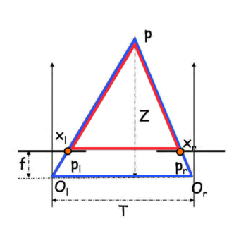

In [7]:
imshow(cv2.imread("../assets/lec13.png"))

Noticing that $\Delta PX_lX_r \sim \Delta PP_lO_r$. so that $$\frac{T}{x_r-x_l} = \frac{Z}{f}\Rightarrow Z = \frac{fT}{x_r - x_l}$$

Then, to get $x_r$, we need to match the point in two images. Since we know $y$ of the point is constant, we can do a sliding window scan along the same $y$, then patch around $x_r$ to get the highest similarity. 